# 1 Imports

In [2]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
import matplotlib.pyplot as plt

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

c:\Users\filip\GitHub\Mastering-LLM-Agentic-AI\venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\filip\.cache\huggingface\hub\models--tiiuae--falcon-7b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

# 2 Connect to OpenAI & HuggingFace

In [3]:
# Load environment variables in a file called .env

load_dotenv()
api_key = os.getenv('OPEN_API_KEY')

In [4]:
# Load environment variables in a file called .env

load_dotenv()
hf_token = os.getenv('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# 3 Dataset Treatment

## 3.1 Load Dataset

In [5]:
dataset = load_dataset('McAuley-Lab/Amazon-Reviews-2023', f'raw_meta_Appliances', split='full', trust_remote_code=True)

In [6]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


## 3.2 Dataset investigation

In [7]:
# Investigate

datapoint = dataset[0]

print(f"Title: {datapoint['title']}")
print(f"Description: {datapoint['description']}")
print(f"Features: {datapoint['features']}")
print(f"Details: {datapoint['details']}")
print(f"Price: {datapoint['price']}")

Title: ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)
Description: []
Features: ['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food', '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like', '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take it out and make you cool', '【Full Monitoring】 Designed with compressor cooling system, o

## 3.3 Price Extraction

In [8]:
prices = 0
prices_df = []

for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            prices += 1
            prices_df.append(price)
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


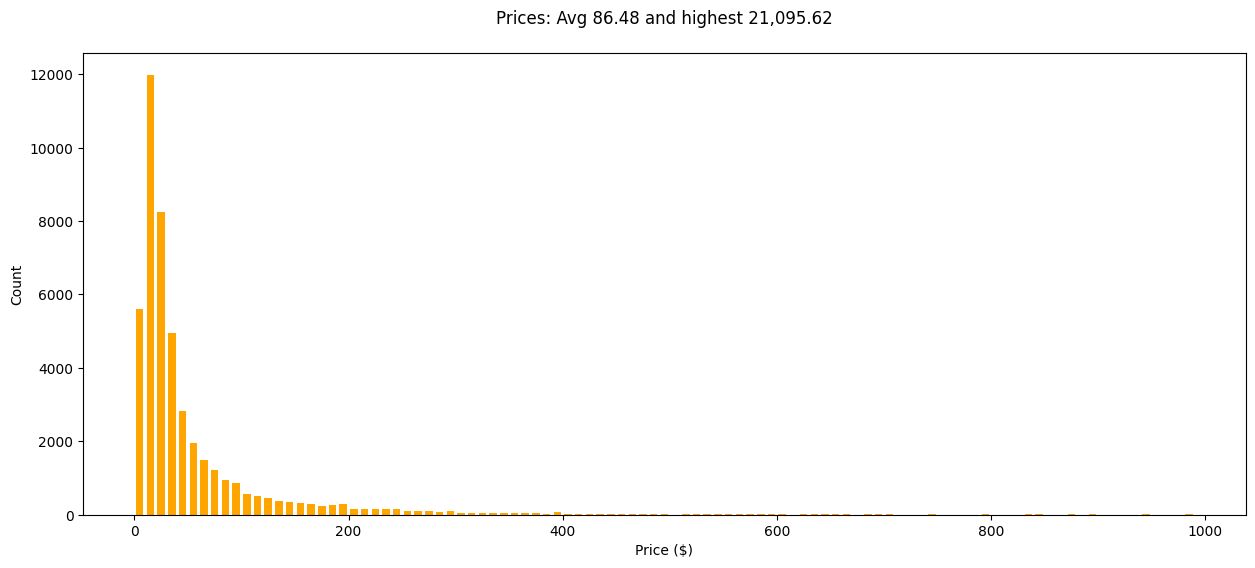

In [9]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices_df)/len(prices_df):.2f} and highest {max(prices_df):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices_df, rwidth=.7, color='orange', bins=range(0, 1000, 10))
plt.show()

## 3.4 Data Cleansing

In [10]:
items = []

for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 29,743 items


In [11]:
# Look at the first item
items[0]

<WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003 = $8.99>

In [13]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort

Price is $17.00


In [15]:
# Investigate the prompt that will be used during testing - the model has to complete this

print(items[1].test_prompt())

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort

Price is $


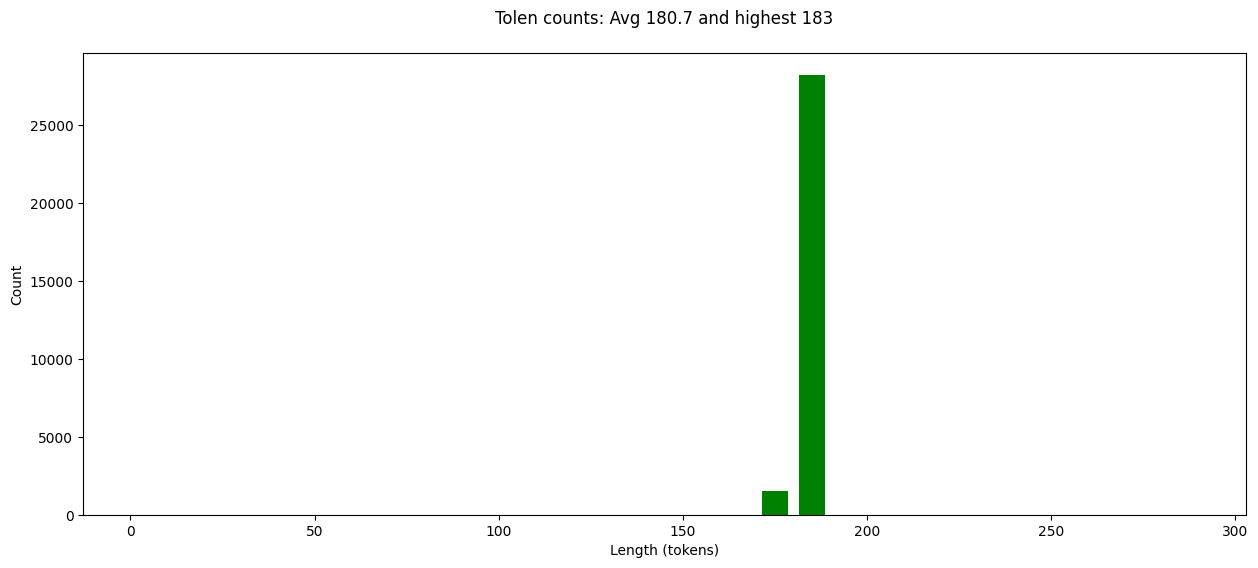

In [16]:
# Plot the distribution of tokens counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Tolen counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color='green', bins=range(0, 300, 10))
plt.show()

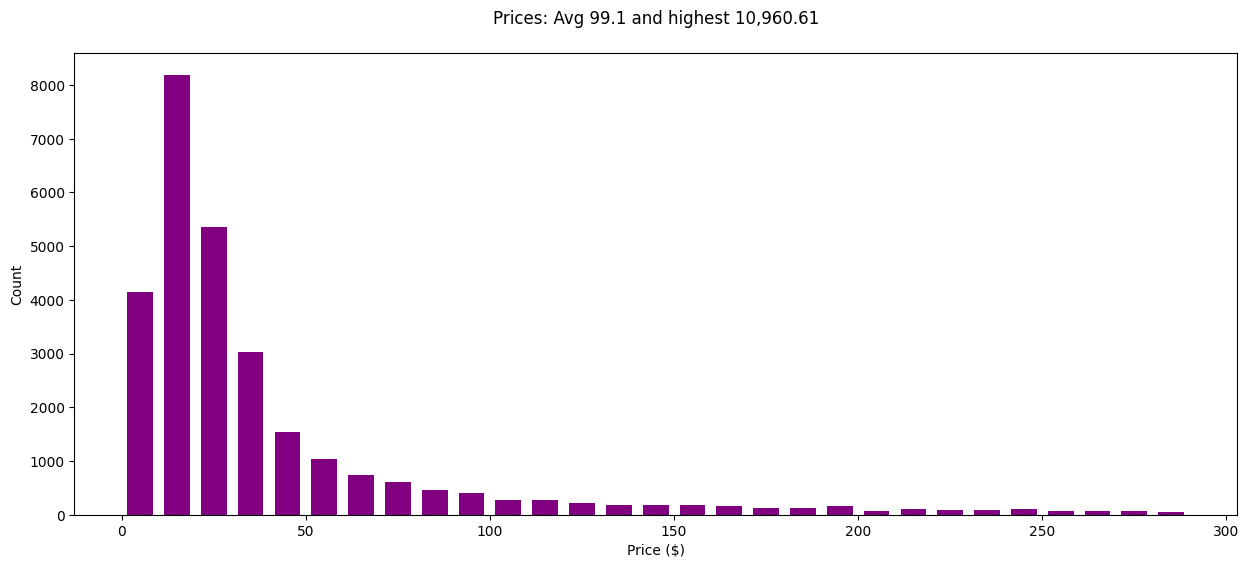

In [18]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=.7, color='purple', bins=range(0, 300, 10))
plt.show()